In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-09-26 14:38:55.869262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 14:38:59.736627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%%bash

#Download model weights
for fold in f0 f1 f2 f3; do
  mkdir -p "saved_models/$fold/"
  local_model="saved_models/$fold/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$fold model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$fold/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
if [ -f gencode41_basic_nort.gtf ]; then
  echo "Annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
fi
if [ -f gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
fi
if [ -f polyadb_human_v3.csv.gz ]; then
  echo "PolyA sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
if [ -f hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
fi

bash: /home/jlinder/anaconda3/envs/borzoi_py39_2/lib/libtinfo.so.6: no version information available (required by bash)


f0 model already exists.
f1 model already exists.
f2 model already exists.
f3 model already exists.
Annotation already exists.
Splice sites already exist.
PolyA sites already exist.
Human genome FASTA already exists.


In [3]:
pyfaidx.Faidx('hg38.fa')

Faidx("hg38.fa")

In [4]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 1       #To use only one model fold, set to 'n_folds = 1'. To use all four folds, set 'n_folds = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, '0')
    
    models.append(seqnn_model)


2023-09-26 14:39:51.526063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10372 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:81:00.0, compute capability: 6.1


In [5]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load APA atlas

apa_df = pd.read_csv('polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

print("len(apa_df) = " + str(len(apa_df)))


len(apa_df) = 114605


In [6]:
#Print index of GTEx muscle and heart tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))
print("heart tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:heart']['local_index'].tolist()))


muscle tracks = [47, 48, 49]
heart tracks = [35, 36, 37]


2023-09-26 14:41:44.072667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-26 14:41:44.604587: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


-- Counts --
 - max_y_wt = 476660.53
 - max_y_mut = 565634.94
 -- (max_y = 565634.94)


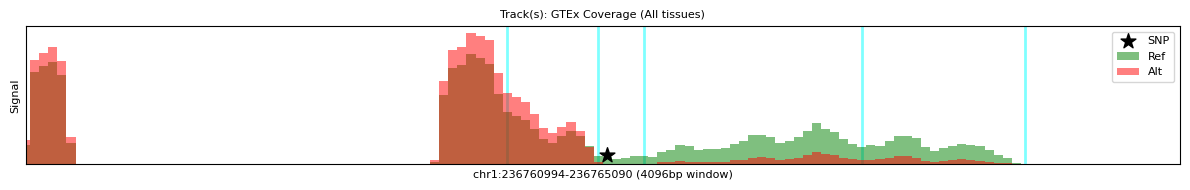

 - max_y_wt = 10086067.0
 - max_y_mut = 11913055.0
 -- (max_y = 11913055.0)


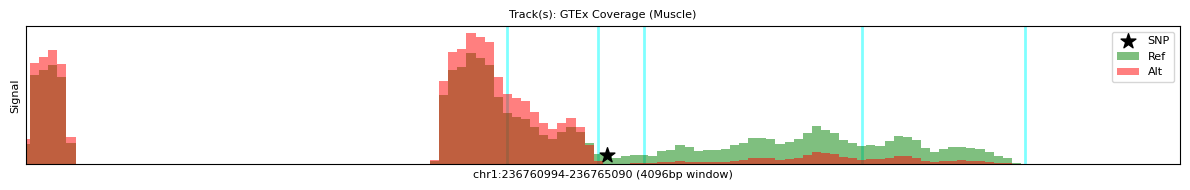

 - max_y_wt = 4045946.0
 - max_y_mut = 4857468.0
 -- (max_y = 4857468.0)


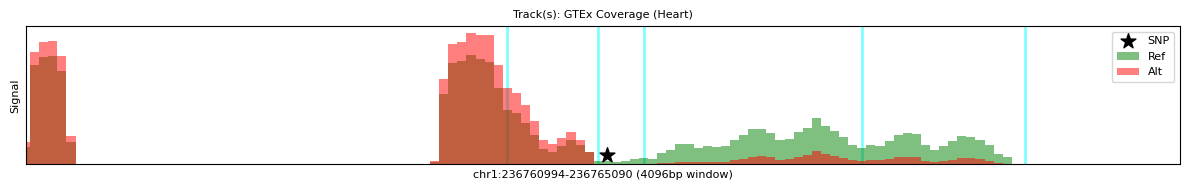

CPU times: user 13.7 s, sys: 731 ms, total: 14.4 s
Wall time: 16.8 s


In [7]:
%%time
#Predict for chr1_236763042_A_G
# (~6 minutes on CPU w 1 fold; ~15 seconds on GPU)

save_figs = False
save_suffix = '_chr1_236763042_A_G'

center_pos = 236763042

chrom = 'chr1'
poses = [236763042]
alts = ['G']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 4096
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = apa_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [47, 48, 49],
    [35, 36, 37],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Muscle)',
    'GTEx Coverage (Heart)',
]

track_scales = [0.01]*3
track_transforms = [3./4.]*3
soft_clips = [384.]*3

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=8*plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    anno_df=anno_df
)


In [8]:
#Print polyA site bin positions and other info

plot_start = center_pos - plot_window // 2
plot_end = center_pos + plot_window // 2

plot_start_bin = (plot_start - start) // bin_size - pad
plot_end_bin = (plot_end - start) // bin_size - pad

mut_bin = (poses[0] - start) // bin_size - pad

#Get polyA site positions
pas_poses = apa_df.query("chrom == '" + chrom + "' and position_hg38 >= " + str(plot_start) + " and position_hg38 < " + str(plot_end))['position_hg38'].values.tolist()

print("mut_bin = " + str(mut_bin))
print("")

#Print polyA site positions
for pas_ix, pas_pos in enumerate(pas_poses) :
    
    pas_bin = int((pas_pos - start) // 32) - 16
    
    bin_end = pas_bin + 3
    bin_start = bin_end - 5
    
    print("pas_ix = " + str(pas_ix) + ": bin = " + str(pas_bin) + " (" + str(bin_start) + " - " + str(bin_end) + ")")


mut_bin = 8176

pas_ix = 0: bin = 8165 (8163 - 8168)
pas_ix = 1: bin = 8175 (8173 - 8178)
pas_ix = 2: bin = 8180 (8178 - 8183)
pas_ix = 3: bin = 8204 (8202 - 8207)
pas_ix = 4: bin = 8222 (8220 - 8225)


In [9]:
#Choose polyA sites to use for attributions

prox_pas_pos = pas_poses[1]

prox_pas_bin = 8175
dist_pas_bin = 8222


In [10]:
%%time
#Get contribution scores (gradient) for pooled GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    target_index[np.arange(0, 89).tolist()].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_folds).tolist(),
)


1/1 [==============================] - 220s 220s/step
CPU times: user 18min 49s, sys: 2min 44s, total: 21min 33s
Wall time: 22min 16s


--- WT ---


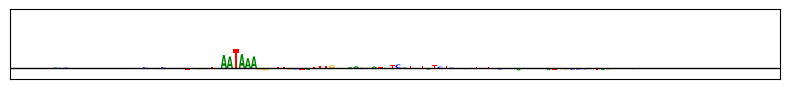

--- Mut ---


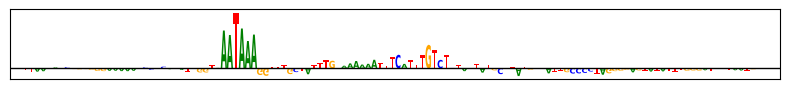

In [11]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [12]:
%%time
#Get contribution scores (ISM) for pooled GTEX tracks
# (not feasible to run on CPU; ~30 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (prox_pas_pos - start) + 3 - 64,
    (prox_pas_pos - start) + 3 + 64,
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    np.arange(0, 89).tolist(),
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


example_ix = 0
example_ix = 1
CPU times: user 16min 8s, sys: 1min 21s, total: 17min 30s
Wall time: 33min 52s


--- WT ---


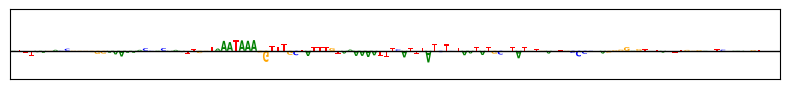

--- Mut ---


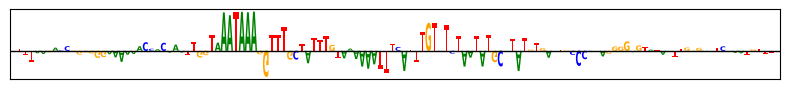

In [13]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [14]:
%%time
#Get contribution scores (ISM shuffle) for pooled GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (prox_pas_pos - start) + 3 - 64,
    (prox_pas_pos - start) + 3 + 64,
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    np.arange(0, 89).tolist(),
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=12,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


example_ix = 0
example_ix = 1
CPU times: user 1h 4min 15s, sys: 5min 30s, total: 1h 9min 46s
Wall time: 2h 15min 18s


--- WT ---


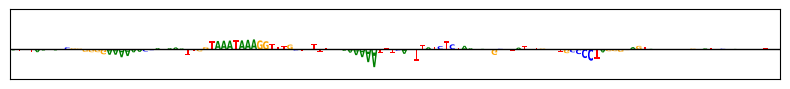

--- Mut ---


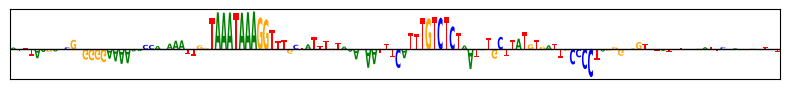

In [15]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [16]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr1_236763042_A_G.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr1_236763042_A_G.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 6)
gtex_targets_mut.shape = (16352, 6)
 - max_y_wt = 110282.92
 - max_y_mut = 108429.734
 -- (max_y = 110282.92)


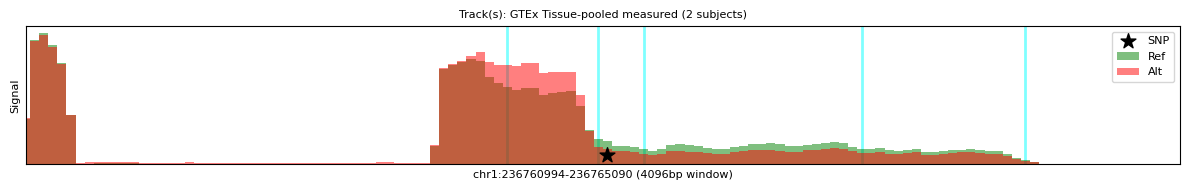

 - max_y_wt = 97425.34
 - max_y_mut = 96755.266
 -- (max_y = 97425.34)


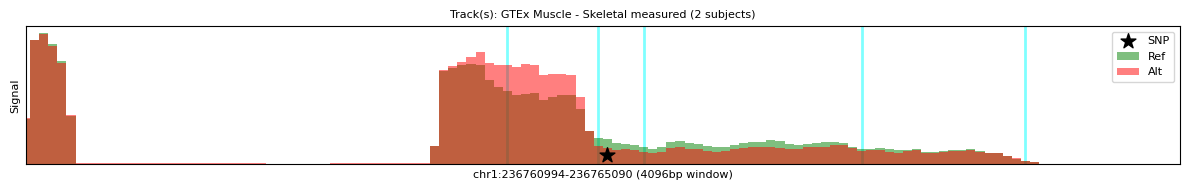

 - max_y_wt = 96052.87
 - max_y_mut = 95051.46
 -- (max_y = 96052.87)


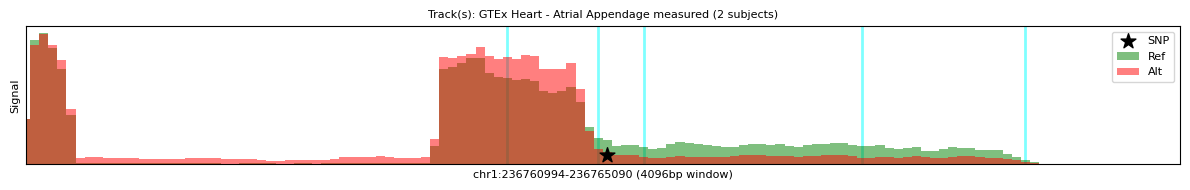

 - max_y_wt = 137370.53
 - max_y_mut = 138814.69
 -- (max_y = 138814.69)


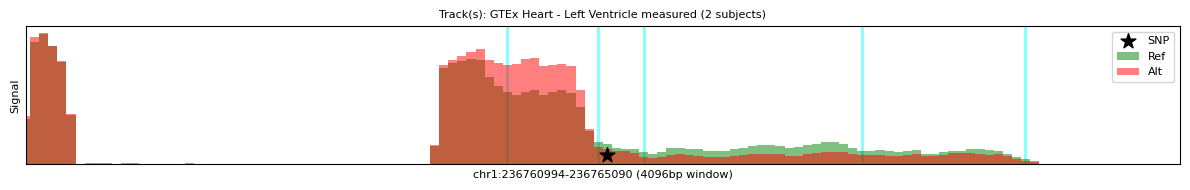

In [17]:
#Read measured coverage tracks for chr1_236763042_A_G

save_figs = False
save_suffix = '_chr1_236763042_A_G_meas_2_subjects'

center_pos = 236763042

chrom = 'chr1'
poses = [236763042]
alts = ['G']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 4096
bin_size = 32
pad = 16

anno_df = apa_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(6).tolist(),
    [0, 1],
    [2, 3],
    [4, 5],
]

track_names = [
    'GTEx Tissue-pooled measured (2 subjects)',
    'GTEx Muscle - Skeletal measured (2 subjects)',
    'GTEx Heart - Atrial Appendage measured (2 subjects)',
    'GTEx Heart - Left Ventricle measured (2 subjects)',
]

track_scales = [0.01]*4
track_transforms = [3./4.]*4
soft_clips = [384.]*4

plot_coverage_track_pair_bins(
    gtex_targets_wt[None, None, ...],
    gtex_targets_mut[None, None, ...],
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=8*plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    anno_df=anno_df
)
